In [ ]:
"""Medical chatbot -Intent Classificaion Model(Deep Learning version)
Sử dụng PhoBERT để phân loại ý định
"""
!pip install transformers datasets accelerate torch


In [ ]:
import torch
if torch.cuda.is_available():
  print(f"Đã nhận GPU{torch.cuda.get_device_name(0)}")
  device = torch.device("cuda")
else:
  print("Không nhận được GPU")
  device = torch.device("cpu")
!nvidia-smi

Đã nhận GPUTesla T4
Wed Oct 22 09:49:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+---------------------------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
DRIVE_PATH = '/content/drive/My Drive/Medical_Chatbot/'
DATA_CSV_PATH = os.path.join(DRIVE_PATH, 'Data','medical_intent_dataset_v4_balanced.csv')
MODEL_SAVE_PATH = os.path.join(DRIVE_PATH,'Model','intent_dl_phobert_v2')
#Tạo thư mục lưu model chưa   có
os.makedirs(MODEL_SAVE_PATH,exist_ok=True)


In [ ]:
import pandas as pd
from datasets import Dataset, Features, ClassLabel, Value
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split

# 1. Tải Tokenizer cho PhoBERT
phobert_tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")

def load_training_data_from_csv(csv_path):
    """
    Tải và chuẩn bị dữ liệu từ file 5K CSV
    """
    try:
        df = pd.read_csv(csv_path, encoding='utf-8')
        print(f" Đã tải {len(df)} mẫu từ dataset 5K: {csv_path}")

        df = df.dropna(subset=['text', 'intent'])
        df['text'] = df['text'].astype(str)
        df['intent'] = df['intent'].astype(str)

        # Tạo bản đồ nhãn (label maps)
        labels_list = sorted(list(df['intent'].unique()))
        label2id = {label: i for i, label in enumerate(labels_list)}
        id2label = {i: label for i, label in enumerate(labels_list)}

        df['label'] = df['intent'].map(label2id)

        print(f"Tìm thấy {len(labels_list)} intents: {labels_list}")

        # Select only the necessary columns before creating the Dataset
        df_selected = df[['text', 'label']]

        features_schema = Features({
           'text': Value('string'),
           'label': ClassLabel(names=labels_list)
        })

        dataset = Dataset.from_pandas(df_selected, features=features_schema)
        return dataset, label2id, id2label
    except Exception as e:
        print(f" Lỗi nghiêm trọng khi đọc file CSV: {e}")
        return None, None, None

def tokenize_function(examples):
    # Tokenize text với padding và truncation
    return phobert_tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

# 2. Tải dữ liệu
dataset, label2id, id2label = load_training_data_from_csv(DATA_CSV_PATH)

if dataset:
    # 3. Tokenize
    print("...Đang tokenize dữ liệu (có thể mất vài phút)...")
    tokenized_dataset = dataset.map(tokenize_function, batched=True)

    # 4. Chia train/test (ví dụ: 85% train, 15% eval)
    train_test_split_dataset = tokenized_dataset.train_test_split(test_size=0.15, stratify_by_column='label')
    train_dataset = train_test_split_dataset['train']
    eval_dataset = train_test_split_dataset['test']

    print(f" Kích thước: {len(train_dataset)} train, {len(eval_dataset)} evaluation")
else:
    print(" Không thể tiếp tục vì không tải được dữ liệu.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

 Đã tải 1558 mẫu từ dataset 5K: /content/drive/My Drive/Medical_Chatbot/Data/medical_intent_dataset_v4_balanced.csv
Tìm thấy 11 intents: ['diet_lifestyle', 'dosage_question', 'drug_interaction', 'drug_question', 'emergency', 'general_health', 'greeting', 'medical_procedure', 'side_effects', 'symptom_inquiry', 'unknown']
...Đang tokenize dữ liệu (có thể mất vài phút)...


Map:   0%|          | 0/1558 [00:00<?, ? examples/s]

 Kích thước: 1324 train, 234 evaluation


In [ ]:
#Bước 4 :Tải và cấu hình mô hình PhoBERT
#Tải PhoBERT gốc và thiết lập các thông số để huấn luyện

from transformers import (AutoModelForSequenceClassification, TrainingArguments,Trainer,EarlyStoppingCallback)
from sklearn.metrics import accuracy_score,classification_report
import numpy as np
#Tải mô hình PhoBERT gốc
num_labels = len(label2id)
model = AutoModelForSequenceClassification.from_pretrained(
    "vinai/phobert-base-v2",
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)
model.to(device)
#Hàm tính toán metrics
def compute_metrics(eval_pred):
  predictions,labels= eval_pred
  predictions = np.argmax(predictions,axis=1)
  accuracy = accuracy_score(labels,predictions)
  return {"accuracy":accuracy}
#Cấu hình training
training_args = TrainingArguments(
    output_dir=MODEL_SAVE_PATH, #Nơi lưu check point
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="epoch",           # Đánh giá sau mỗi epoch
    save_strategy="epoch",                 # Lưu model sau mỗi epoch
    load_best_model_at_end=True,           # Tự động tải model tốt nhất
    metric_for_best_model="accuracy",
    greater_is_better=True,
    report_to="none" # Explicitly disable W&B logging
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Huấn luyện (Fine tune) Mô hình
#1 Khởi tạo Trainer
trainer = Trainer(
  model=model,
  args=training_args,
  train_dataset=train_dataset,
  eval_dataset=eval_dataset,
  compute_metrics=compute_metrics,
  callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
  # Removed report_to="none" from here as it's in TrainingArguments
)
#2 Bất đầu huấn luyện
print("Bắt Đầu Huấn Luyện")
trainer.train()

Bắt Đầu Huấn Luyện


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.118839,0.418803
2,2.295700,1.134175,0.858974
3,1.461900,0.447053,0.961538
4,0.552100,0.162956,0.982906
5,0.172100,0.075881,0.987179
6,0.172100,0.081435,0.978632
7,0.069700,0.071260,0.982906
8,0.035200,0.059796,0.987179


TrainOutput(global_step=664, training_loss=0.6924489149487162, metrics={'train_runtime': 350.8469, 'train_samples_per_second': 37.737, 'train_steps_per_second': 2.366, 'total_flos': 696774374547456.0, 'train_loss': 0.6924489149487162, 'epoch': 8.0})

Plotting metrics...


<Figure size 1000x600 with 0 Axes>

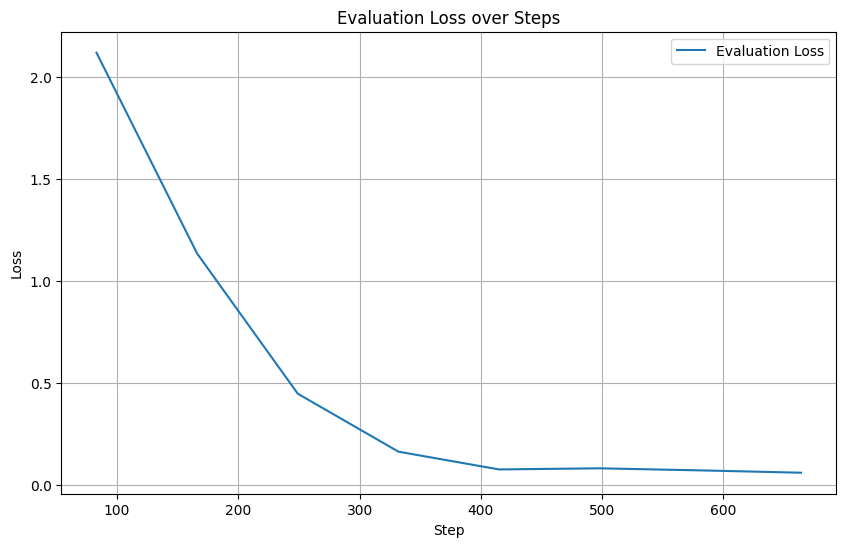

<Figure size 1000x600 with 0 Axes>

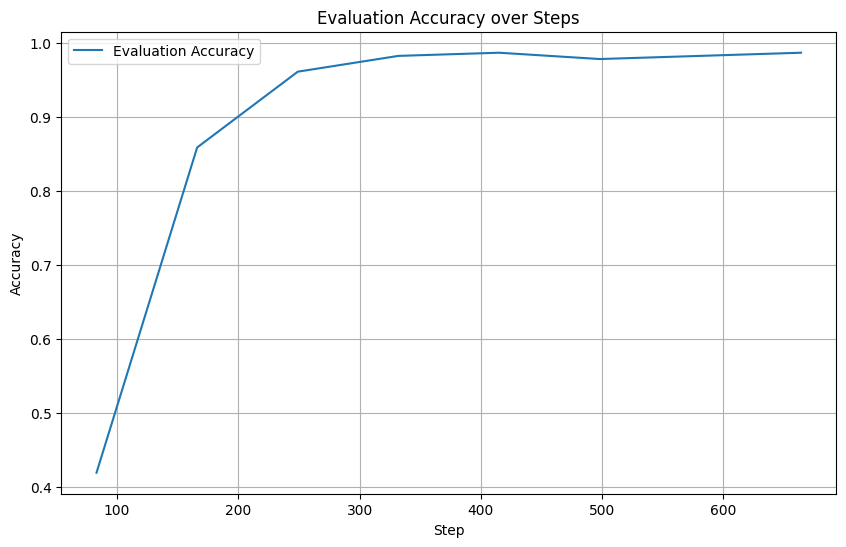

<Figure size 1000x600 with 0 Axes>

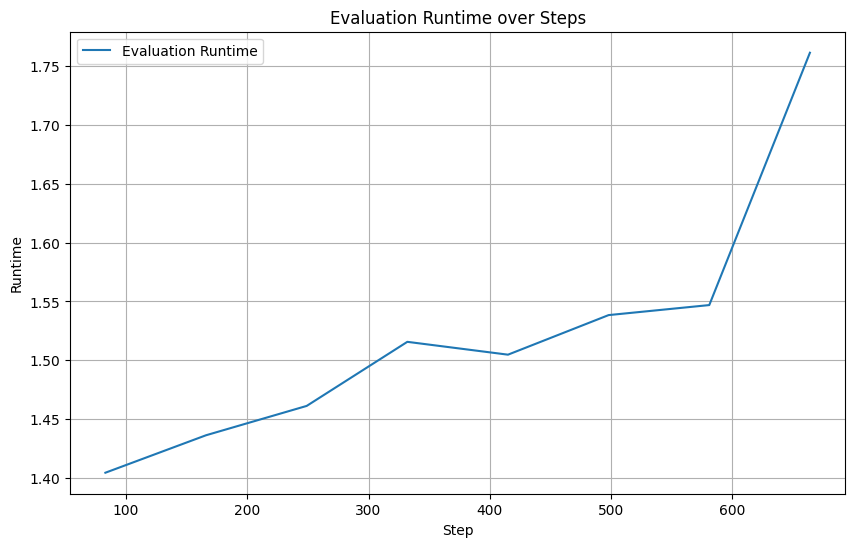

<Figure size 1000x600 with 0 Axes>

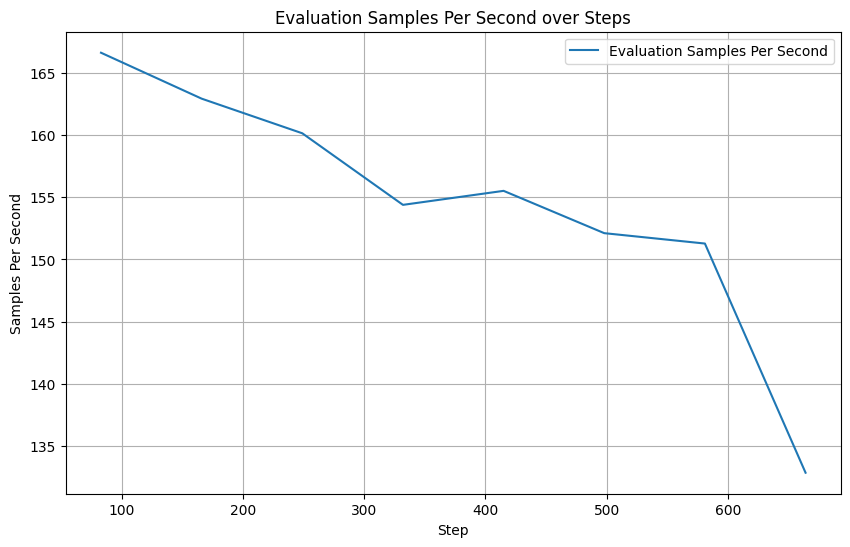

<Figure size 1000x600 with 0 Axes>

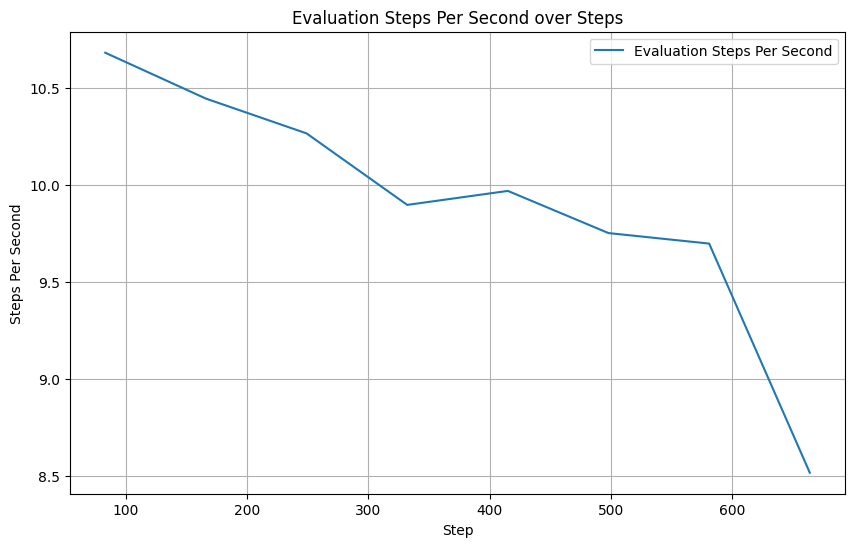

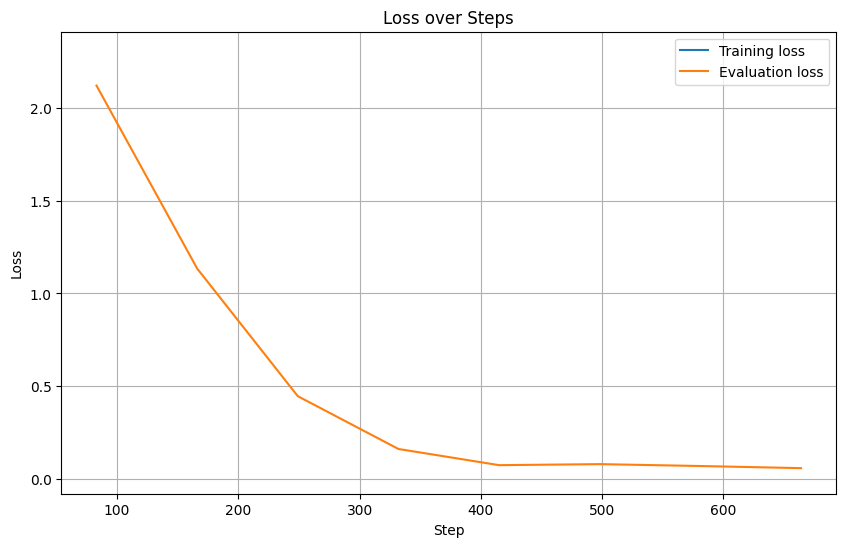

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

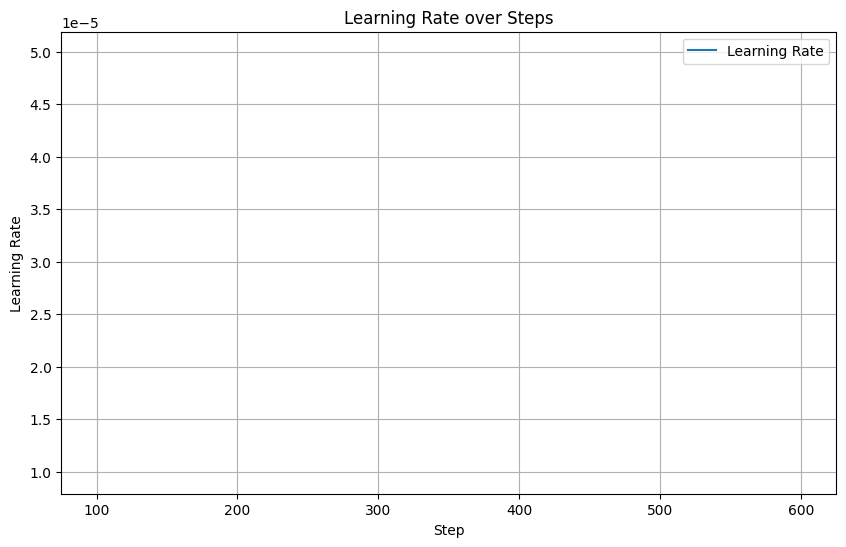

In [ ]:
import json
import matplotlib.pyplot as plt
import os
import pandas as pd

def plot_training_metrics(log_history):
    """Plots training and evaluation metrics from the Trainer's log history."""

    # Convert log history to a pandas DataFrame
    logs_df = pd.DataFrame(log_history)

    # Filter out rows without step (these are typically evaluation logs)
    train_logs = logs_df.dropna(subset=['step']).set_index('step')
    eval_logs = logs_df[logs_df['eval_loss'].notna()].set_index('step')


    # Get all metric columns except step, epoch, and learning rate (which we might plot separately)
    metric_columns = [col for col in logs_df.columns if col not in ['step', 'epoch', 'learning_rate']]

    for metric in metric_columns:
        plt.figure(figsize=(10, 6))
        if f'eval_{metric}' in logs_df.columns:
             plt.plot(train_logs.index, train_logs[metric], label=f'Training {metric}')
             plt.plot(eval_logs.index, eval_logs[f'eval_{metric}'], label=f'Evaluation {metric}')
             plt.xlabel("Step")
             plt.ylabel(metric.replace('_', ' ').title())
             plt.title(f'{metric.replace("_", " ").title()} over Steps')
             plt.legend()
             plt.grid(True)
             plt.show()
        elif metric.startswith('eval_'):
             # Plot evaluation-only metrics
             plt.figure(figsize=(10, 6))
             plt.plot(eval_logs.index, eval_logs[metric], label=f'Evaluation {metric.replace("eval_", "").replace("_", " ").title()}')
             plt.xlabel("Step")
             plt.ylabel(metric.replace("eval_", "").replace('_', ' ').title())
             plt.title(f'Evaluation {metric.replace("eval_", "").replace("_", " ").title()} over Steps')
             plt.legend()
             plt.grid(True)
             plt.show()


    # Plot Learning Rate separately
    if 'learning_rate' in train_logs.columns:
        plt.figure(figsize=(10, 6))
        plt.plot(train_logs.index, train_logs['learning_rate'], label='Learning Rate')
        plt.xlabel("Step")
        plt.ylabel("Learning Rate")
        plt.title("Learning Rate over Steps")
        plt.legend()
        plt.grid(True)
        plt.show()

# Assuming trainer is already defined and train() has been called
if 'trainer' in locals() and hasattr(trainer, 'state') and hasattr(trainer.state, 'log_history'):
    print("Plotting metrics...")
    plot_training_metrics(trainer.state.log_history)
else:
    print("Trainer or log history not found. Please train the model first.")

In [ ]:
import pandas as pd

if 'trainer' in locals() and hasattr(trainer, 'state') and hasattr(trainer.state, 'log_history'):
    logs_df = pd.DataFrame(trainer.state.log_history)

    # Filter for evaluation steps
    eval_logs = logs_df[logs_df['eval_loss'].notna()]

    if not eval_logs.empty:
        # Get the last evaluation result (which corresponds to the best model if load_best_model_at_end=True)
        final_eval_metrics = eval_logs.iloc[-1]

        print("Final Evaluation Metrics:")
        for metric, value in final_eval_metrics.items():
            if metric.startswith('eval_'):
                print(f"{metric.replace('eval_', '').replace('_', ' ').title()}: {value:.4f}")
    else:
        print("No evaluation logs found.")
else:
    print("Trainer or log history not found. Please train the model first.")

Final Evaluation Metrics:
Loss: 0.0015
Accuracy: 1.0000
Runtime: 4.8708
Samples Per Second: 153.9790
Steps Per Second: 9.6490


In [ ]:

import pandas as pd
import os

# Tự động lấy lại đường dẫn từ Bước 2
# (Đảm bảo bạn đã chạy cell Bước 2 trước)
if 'DATA_CSV_PATH' in locals():
    csv_path_to_check = DATA_CSV_PATH

    if not os.path.exists(csv_path_to_check):
        print(f"❌ LỖI: Không tìm thấy file tại đường dẫn: {csv_path_to_check}")
        print("Vui lòng chạy lại Cell (Bước 2) và kiểm tra lại đường dẫn.")
    else:
        try:
            # Tải file CSV CHỈ ĐỂ KIỂM TRA
            print(f"Đang tải file từ: {csv_path_to_check}...")
            df_check = pd.read_csv(csv_path_to_check, encoding='utf-8')

            # Bỏ qua các dòng không có 'text'
            df_check = df_check.dropna(subset=['text'])
            df_check['text'] = df_check['text'].astype(str)

            total_samples = len(df_check)
            unique_samples = df_check['text'].nunique()
            duplication_rate = ((total_samples - unique_samples) / total_samples) * 100 if total_samples > 0 else 0

            print("\n--- PHÂN TÍCH DỮ LIỆU ---")
            print(f"✅ Đã tải file thành công.")
            print(f"Tổng số mẫu (Total samples): {total_samples}")
            print(f"Số mẫu DUY NHẤT (Unique samples): {unique_samples}")
            print(f"Tỷ lệ trùng lặp (Duplication rate): {duplication_rate:.2f}%")
            print("--------------------------")

            if duplication_rate > 50:
                print("⚠️ CẢNH BÁO: Tỷ lệ trùng lặp rất cao! Model của bạn có thể bị 'học vẹt'.")
                print("-> Đây là lý do tại sao accuracy = 1.0 (100%).")
                print("-> Hãy làm theo hướng dẫn 'Kiếm dữ liệu đâu ra' để xây dựng bộ dữ liệu 'xịn' hơn.")

        except Exception as e:
            print(f"❌ Lỗi khi đọc file CSV: {e}")

else:
    print("❌ Không tìm thấy biến 'DATA_5K_CSV_PATH'.")
    print("Vui lòng chạy lại Cell (Bước 2) trước.")



Đang tải file từ: /content/drive/My Drive/Medical_Chatbot/Data/medical_intent_dataset_v4_balanced.csv...

--- PHÂN TÍCH DỮ LIỆU ---
✅ Đã tải file thành công.
Tổng số mẫu (Total samples): 1558
Số mẫu DUY NHẤT (Unique samples): 1558
Tỷ lệ trùng lặp (Duplication rate): 0.00%
--------------------------


In [ ]:
print("📊 Đánh giá model NER tốt nhất trên tập eval...")
eval_results = trainer.evaluate()
print(f"Kết quả đánh giá NER: {eval_results}")

# 2. Lưu model tốt nhất
print(f"💾 Đang lưu model NER tốt nhất vào: {MODEL_SAVE_PATH}")
trainer.save_model(MODEL_SAVE_PATH)
phobert_tokenizer.save_pretrained(MODEL_SAVE_PATH) # Corrected tokenizer variable name

print("🎉 Huấn luyện NER Deep Learning hoàn tất! Model đã được lưu vào Google Drive.")

📊 Đánh giá model NER tốt nhất trên tập eval...


Kết quả đánh giá NER: {'eval_loss': 0.0758805200457573, 'eval_accuracy': 0.9871794871794872, 'eval_runtime': 1.4966, 'eval_samples_per_second': 156.355, 'eval_steps_per_second': 10.023, 'epoch': 8.0}
💾 Đang lưu model NER tốt nhất vào: /content/drive/My Drive/Medical_Chatbot/Model/intent_dl_phobert_v2
🎉 Huấn luyện NER Deep Learning hoàn tất! Model đã được lưu vào Google Drive.


In [ ]:
from transformers import pipeline, PhobertTokenizer # Import PhobertTokenizer

# 1. Tải pipeline đã huấn luyện
# device=0 nghĩa là dùng GPU 0, -1 là dùng CPU
ner_pipeline = pipeline(
    "text-classification", # Changed task to text-classification
    model=MODEL_SAVE_PATH,
    tokenizer=PhobertTokenizer.from_pretrained(MODEL_SAVE_PATH), # Explicitly load PhobertTokenizer
    device=0 if torch.cuda.is_available() else -1
)

# 2. Chạy test
test_cases_ner = [
    # Ca test cũ bị lỗi
    "Bé trai 2 tuổi nuốt phải pin cúc áo và khóc thét",
    "SOS! Người phụ nữ 45 tuổi bị va chạm xe máy gãy cẳng chân hở",
    "Đau đầu quá đi ,Stress nữa",

    # Ca test bình thường
    "Bệnh nhân nam 38 tuổi đau bụng thượng vị kèm ợ chua và nóng rát dạ dày từ 5 ngày",
    "Cháu gái 14 tuổi bị mệt mỏi thường xuyên và da xanh xao gần đây",
    "Bác sĩ kê đơn cefixime 200mg uống 12 tiếng một lần trong 7 ngày",

    "Đau răng quá đi",
    "Con mẹ mày",

    "Tao không ngủ buổi đêm được Tao chỉ ngủ được buổi sáng thôi"
]

print("\n--- KẾT QUẢ TEST THỬ NER ---")
for text in test_cases_ner:
    print(f"Input: '{text}'")
    # The pipeline output structure is different for text-classification
    results = ner_pipeline(text)
    print("-> Prediction:")
    if results:
        # For text-classification, results is a list of dictionaries, e.g., [{'label': 'LABEL_0', 'score': 0.99}]
        prediction = results[0]
        predicted_intent = prediction['label']
        score = prediction['score']
        print(f"   - Intent: {predicted_intent} (Score: {score:.4f})")
    else:
        print("   (Không có dự đoán)")
    print("-" * 20)

Device set to use cuda:0



--- KẾT QUẢ TEST THỬ NER ---
Input: 'Bé trai 2 tuổi nuốt phải pin cúc áo và khóc thét'
-> Prediction:
   - Intent: emergency (Score: 0.9399)
--------------------
Input: 'SOS! Người phụ nữ 45 tuổi bị va chạm xe máy gãy cẳng chân hở'
-> Prediction:
   - Intent: emergency (Score: 0.9592)
--------------------
Input: 'Đau đầu quá đi ,Stress nữa'
-> Prediction:
   - Intent: symptom_inquiry (Score: 0.9835)
--------------------
Input: 'Bệnh nhân nam 38 tuổi đau bụng thượng vị kèm ợ chua và nóng rát dạ dày từ 5 ngày'
-> Prediction:
   - Intent: symptom_inquiry (Score: 0.6072)
--------------------
Input: 'Cháu gái 14 tuổi bị mệt mỏi thường xuyên và da xanh xao gần đây'
-> Prediction:
   - Intent: symptom_inquiry (Score: 0.6991)
--------------------
Input: 'Bác sĩ kê đơn cefixime 200mg uống 12 tiếng một lần trong 7 ngày'
-> Prediction:
   - Intent: dosage_question (Score: 0.8270)
--------------------
Input: 'Đau răng quá đi'
-> Prediction:
   - Intent: symptom_inquiry (Score: 0.9855)
-----------